In [1]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
%matplotlib inline
from IPython.display import HTML , clear_output

In [47]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


pos 는 가중치를 의미

* pos = {'Q0':[0, 0]}의 식으로 node의 이름을 key로, node의 x, y 좌표를 tuple이나 리스트로 value로 넘겨줍니다.
* position embedding을 의미함!

In [48]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

# Network 데이터를 torch_geometric dataset으로 만드는 부분

In [94]:
G = nx.karate_club_graph()
x = torch.eye(G.number_of_nodes(), dtype=torch.float)
x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [98]:
adj = nx.to_scipy_sparse_matrix(G).tocoo()
adj.row.astype(np.int64)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12,
       12, 13, 13, 13, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19,
       19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25,
       25, 25, 26, 26, 27, 27, 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30,
       30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33])

In [100]:
adj.col.astype(np.int64)

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,
        2,  3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28,
       32,  0,  1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5,
       16,  0,  1,  2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4,  5,  0,  0,
        3,  0,  1,  2,  3, 33, 32, 33, 32, 33,  5,  6,  0,  1, 32, 33,  0,
        1, 33, 32, 33,  0,  1, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31, 23,
       24, 31, 29, 33,  2, 23, 24, 33,  2, 31, 33, 23, 26, 32, 33,  1,  8,
       32, 33,  0, 24, 25, 28, 32, 33,  2,  8, 14, 15, 18, 20, 22, 23, 29,
       30, 31, 33,  8,  9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29,
       30, 31, 32])

In [102]:
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)
edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

[community_louvain.best_partition](https://python-louvain.readthedocs.io/en/latest/api.html)

* group을 만들어주는 행위?

In [104]:
partition = community_louvain.best_partition(G)
print(partition)


{0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 2, 7: 0, 8: 3, 9: 3, 10: 2, 11: 0, 12: 0, 13: 0, 14: 3, 15: 3, 16: 2, 17: 0, 18: 3, 19: 0, 20: 3, 21: 0, 22: 3, 23: 1, 24: 1, 25: 1, 26: 3, 27: 1, 28: 1, 29: 3, 30: 3, 31: 1, 32: 3, 33: 3}


In [107]:
## 목표하는 것에 따라서 변경될 수 있어 보임
y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])
print(y)

tensor([0, 0, 0, 0, 2, 2, 2, 0, 3, 3, 2, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 0, 3, 1,
        1, 1, 3, 1, 1, 3, 3, 1, 3, 3])


## train_mask 
이해 안됨/ 왜 하는 것이지?

* train_mask : 학습하기 위해 사용하는 노드들을 가리킴

In [116]:
# Select a single training node for each community
# (we just use the first one).
#  머지???
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
for i in range(int(y.max()) + 1):
    print((y == i).nonzero(as_tuple=False)[0])
    train_mask[(y == i).nonzero(as_tuple=False)[0]] = True
train_mask

tensor([0])
tensor([23])
tensor([4])
tensor([8])


tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False])

In [115]:
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)
data

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])

In [93]:
import community as community_louvain
from torch_geometric.data import InMemoryDataset, Data
G = nx.karate_club_graph()
x = torch.eye(G.number_of_nodes(), dtype=torch.float)

adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# Compute communities.
partition = community_louvain.best_partition(G)
y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])

# Select a single training node for each community
# (we just use the first one).
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
for i in range(int(y.max()) + 1):
    train_mask[(y == i).nonzero(as_tuple=False)[0]] = True
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

In [74]:
type(data)

torch_geometric.data.data.Data

In [80]:
from torch_geometric.data.data import Data as graphData

class GraphDataset(InMemoryDataset):
    r"""Zachary's karate club network from the `"An Information Flow Model for
    Conflict and Fission in Small Groups"
    <http://www1.ind.ku.dk/complexLearning/zachary1977.pdf>`_ paper, containing
    34 nodes, connected by 156 (undirected and unweighted) edges.
    Every node is labeled by one of four classes obtained via modularity-based
    clustering, following the `"Semi-supervised Classification with Graph
    Convolutional Networks" <https://arxiv.org/abs/1609.02907>`_ paper.
    Training is based on a single labeled example per class, *i.e.* a total
    number of 4 labeled nodes.
    ## https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/karate.html
    Args:
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
    """
    def __init__(self, data: graphData , transform=None):
        super(GraphDataset, self).__init__('.', transform, None, None)
        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)


In [81]:
dataset = GraphDataset(data)

In [82]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: GraphDataset():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [84]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


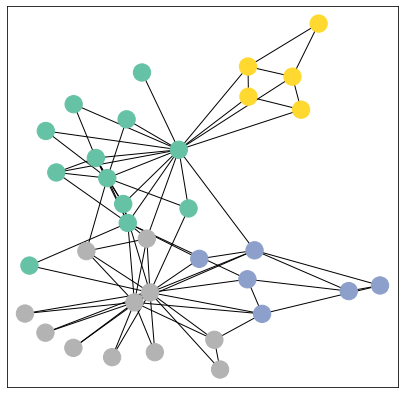

In [86]:
from torch_geometric.utils import to_networkx
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()
G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

In [87]:
# num_features = len(g.nodes)
# num_classses = len(np.unique(labels))

In [88]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


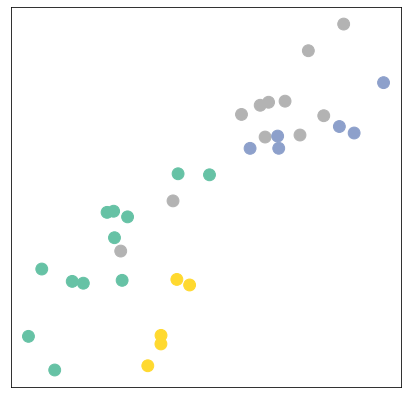

In [89]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

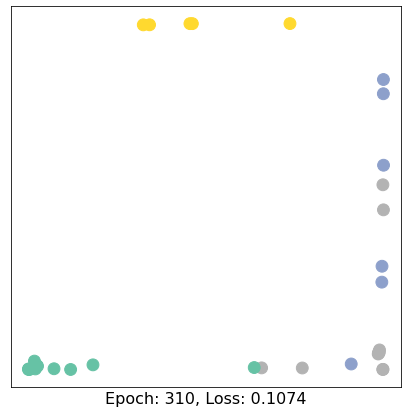

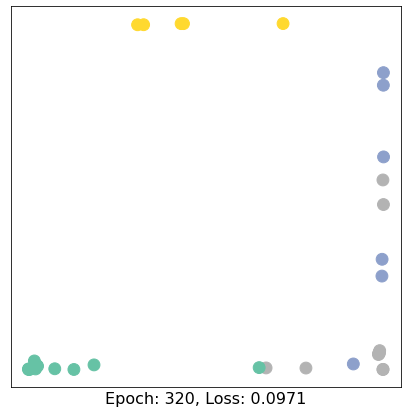

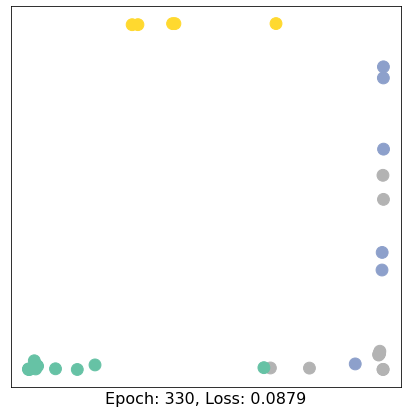

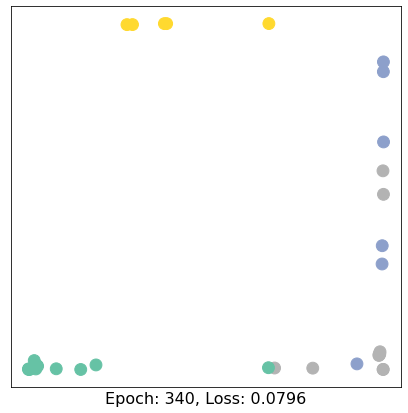

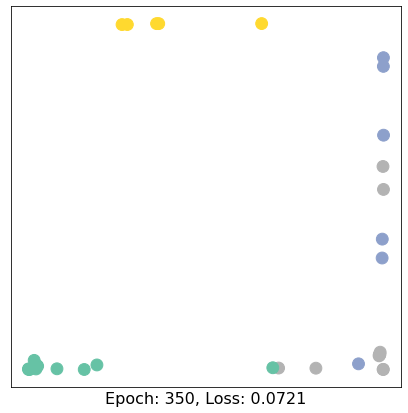

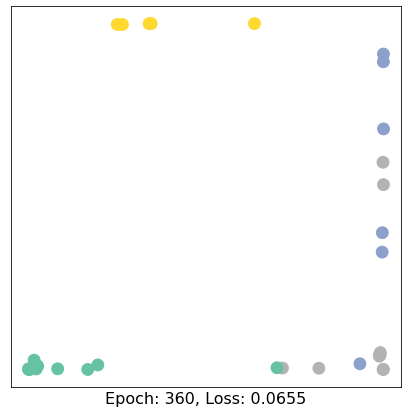

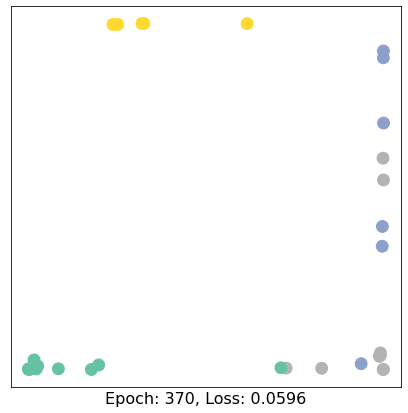

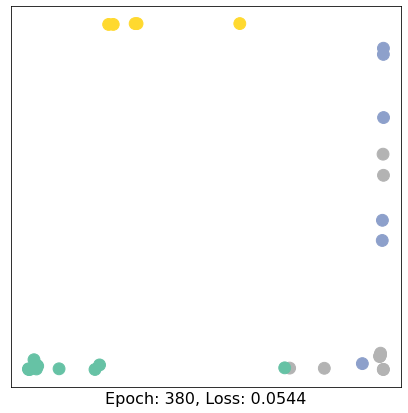

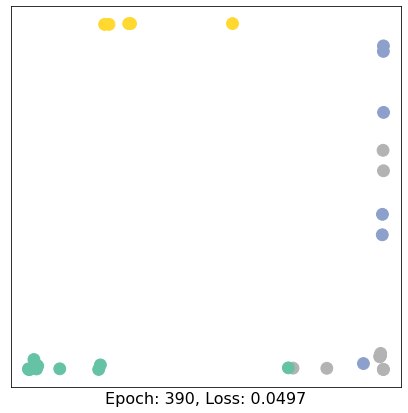

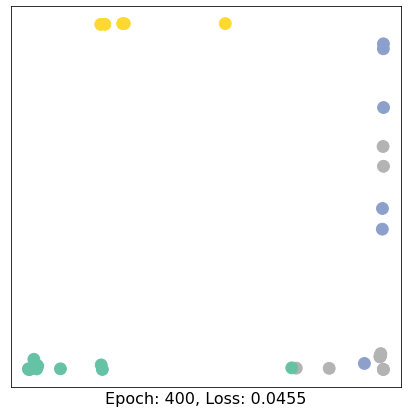

In [92]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)
    if epoch % 100 == 0:
        clear_output(wait=True)

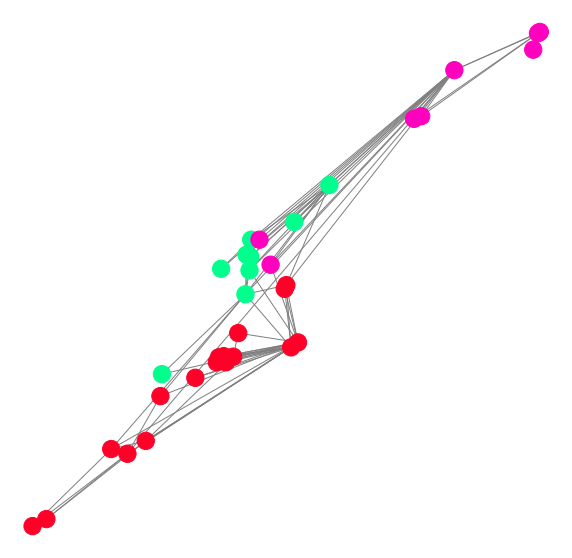

In [123]:
pos = {i: embed[i,:] for i in range(embed.shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

In [124]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])
opt2 = GradDescentOptim(lr=2e-2, wd=2.5e-2)

In [125]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 4e3
# lr_rate_ramp = 0 #-0.05
# lr_ramp_steps = 1000

for epoch in range(15000):
    
    y_pred = gcn_model.forward(A_hat, X)

    opt2(y_pred, labels, train_nodes)
    
#     if ((epoch+1) % lr_ramp_steps) == 0:
#         opt2.lr *= 1+lr_rate_ramp
#         print(f"LR set to {opt2.lr:.4f}")

    for layer in reversed(gcn_model.layers):
        layer.backward(opt2, update=True)
        
    embeds.append(gcn_model.embedding(A_hat, X))
    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.103, Test Loss: 1.103
Epoch: 101, Train Loss: 1.096, Test Loss: 1.096
Epoch: 201, Train Loss: 1.089, Test Loss: 1.087
Epoch: 301, Train Loss: 1.077, Test Loss: 1.071
Epoch: 401, Train Loss: 1.052, Test Loss: 1.039
Epoch: 501, Train Loss: 0.993, Test Loss: 0.965
Epoch: 601, Train Loss: 0.870, Test Loss: 0.810
Epoch: 701, Train Loss: 0.700, Test Loss: 0.630
Epoch: 801, Train Loss: 0.593, Test Loss: 0.541
Epoch: 901, Train Loss: 0.544, Test Loss: 0.510
Epoch: 1001, Train Loss: 0.518, Test Loss: 0.500
Epoch: 1101, Train Loss: 0.501, Test Loss: 0.498
Epoch: 1201, Train Loss: 0.486, Test Loss: 0.500
Epoch: 1301, Train Loss: 0.470, Test Loss: 0.504
Epoch: 1401, Train Loss: 0.449, Test Loss: 0.504
Epoch: 1501, Train Loss: 0.421, Test Loss: 0.499
Epoch: 1601, Train Loss: 0.390, Test Loss: 0.491
Epoch: 1701, Train Loss: 0.357, Test Loss: 0.483
Epoch: 1801, Train Loss: 0.327, Test Loss: 0.477
Epoch: 1901, Train Loss: 0.301, Test Loss: 0.474
Epoch: 2001, Train Loss: 0.280, 

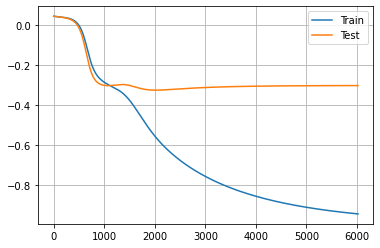

In [126]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

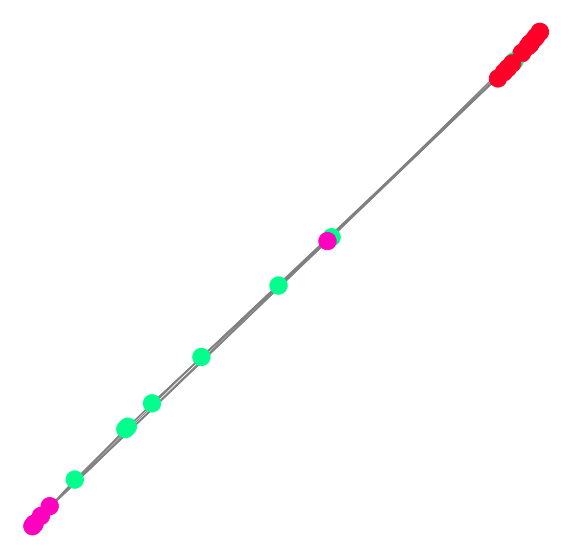

In [127]:

pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

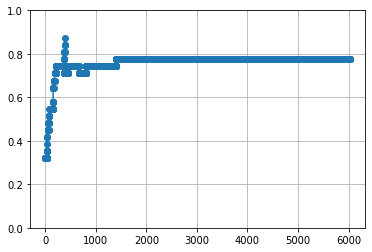

In [128]:

fig, ax = plt.subplots()
_ = ax.plot(accs, marker='o')
ax.grid()
_ = ax.set(ylim=[0,1])

In [129]:
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)

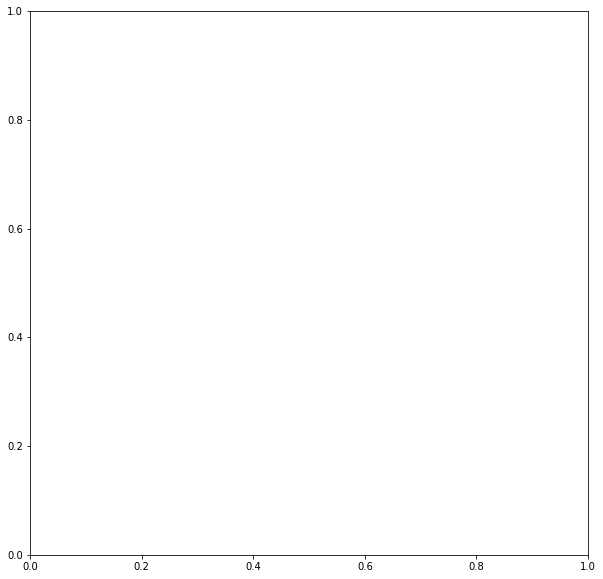

In [95]:

# Build plot
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'gist_rainbow', 'edge_color': 'gray', }#'node_size': 55}

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)

In [48]:

HTML(anim.to_html5_video())

MovieWriter stderr:
[rawvideo @ 0x55702c3766e0] Invalid buffer size, packet size 118784 < expected frame_size 2073600
Error while decoding stream #0:0: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x720', '-pix_fmt', 'rgba', '-r', '100.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpd5b_g6os/temp.m4v']' returned non-zero exit status 255.

In [ ]:
anim.save('embed_anim.mp4', dpi=300)